In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from scipy.stats import shapiro
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve, auc, make_scorer, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import TomekLinks, NearMiss
from pycaret.classification import setup, compare_models, create_model
from pycaret.classification import tune_model, plot_model, evaluate_model, finalize_model
from pycaret.classification import save_model, load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
treino = pd.read_excel('treino.xlsx')

In [61]:
#treino.drop(['V13', 'V5', 'V20', 'V11', 'V6', 'V2'], axis=1, inplace=True)

In [4]:
treino_0 = treino[treino['Class'] == 0]
treino_1 = treino[treino['Class'] == 1]
"""
for i in treino_0.iloc[:, 1:-1].columns:
    print(f'A média da variável {i} para classe 0 é:', treino_0[i].mean())
    print(f'A média da variável {i} para classe 1 é:', treino_1[i].mean())
    print('------------------')
"""

"\nfor i in treino_0.iloc[:, 1:-1].columns:\n    print(f'A média da variável {i} para classe 0 é:', treino_0[i].mean())\n    print(f'A média da variável {i} para classe 1 é:', treino_1[i].mean())\n    print('------------------')\n"

### Separar em treino e teste

In [5]:
#treino = treino.sample(frac=0.5)
X = treino.iloc[:, 1:-1]
y = treino['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Regressão logística

In [6]:
# Treinar e avaliar um modelo de regressão logística
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_val_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_val_logreg)


print("Regressão Logística - Resultados de Validação:")
#print(classification_report(y_val, y_pred_val_logreg))
print("AUC Score:", roc_auc_score(y_test, y_pred_val_logreg))
print("Accuracy:", accuracy_logreg)

Regressão Logística - Resultados de Validação:
AUC Score: 0.7118204405834568
Accuracy: 0.8175480256948884


In [7]:
confusion_matrix(y_test, y_pred_val_logreg)

array([[26811,  5965],
       [   28,    43]], dtype=int64)

In [13]:
scorer = make_scorer(roc_auc_score)
cv_results = cross_validate(logreg, X_train, y_train, cv=10, scoring=scorer, return_estimator=True)
cv_results['test_score']

array([0.7469968 , 0.6638891 , 0.82077251, 0.70309582, 0.64366078,
       0.76293996, 0.78224638, 0.69414297, 0.71241964, 0.69399041])

In [14]:
gtest_score = []
for i in range(len(cv_results['estimator'])):
    gtest_score.append(cv_results['estimator'][i].score(X_test, y_test))
gtest_score

[0.817152251347155,
 0.8301823606417633,
 0.8039090327883825,
 0.8221755411453101,
 0.8180046884038116,
 0.8122811824519743,
 0.8114896337565074,
 0.8176089140560782,
 0.8169391420829908,
 0.8158735957621701]

In [25]:
result = []
for i in range(len(cv_results['estimator'])):
    result.append(cv_results['estimator'][i].predict(X_test))

In [24]:
y_pred = result[1]
print('AUC: ', roc_auc_score(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

AUC:  0.7251782908827139
Accuracy:  0.8301823606417633
Confusion Matrix: 
 [[27225  5551]
 [   27    44]]


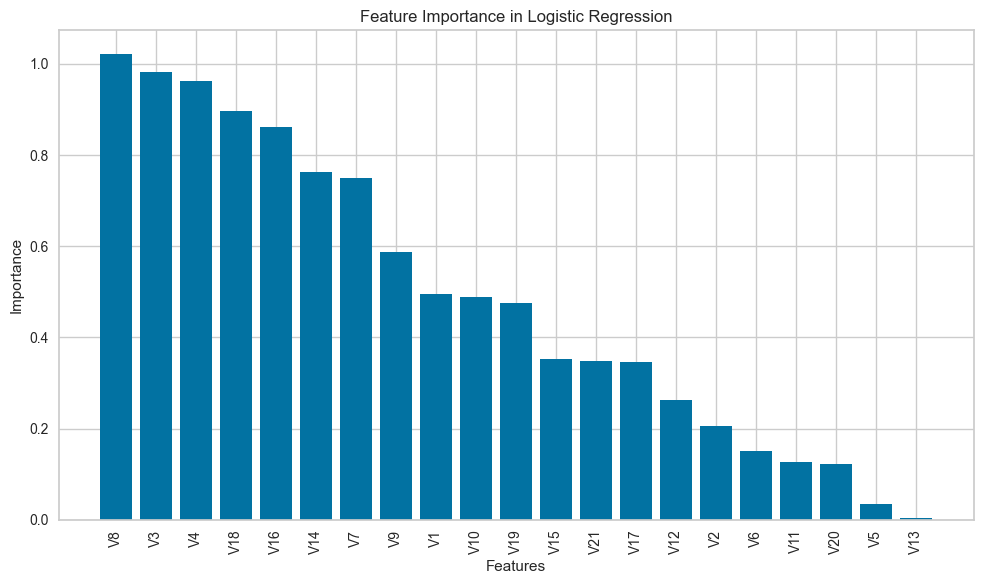

In [54]:
feature_importance = np.abs(logreg.coef_[0])
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]

feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), sorted_importance)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Logistic Regression")
plt.tight_layout()
plt.show()

In [55]:
def punir_os_infieis(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fn_penalty = 3
    fp_penalty = 5
    tn_bonus = -5
    tp_bonus = -3

    loss = fn_penalty * fn + fp_penalty * fp + tn_bonus * tn + tp_bonus * tp
    return -loss

In [56]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
params = {'C': [0.01, 0.1, 1],
          'solver': ['liblinear', 'sag', 'saga'],
          'max_iter':[100,200],
          'penalty': ['l1', 'l2']}

custom_scorer = make_scorer(punir_os_infieis)
model_cv = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'), param_grid=params, scoring=custom_scorer, cv=folds, verbose=1, return_train_score=True)
cv_model = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [57]:
print('Best Params: ', cv_model.best_params_)
print('Best Score: ', cv_model.best_score_)

y_pred = cv_model.predict(X_test)
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('AUC', roc_auc_score(y_test, y_pred))

Best Params:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  83438.0
Precision 0.0071906354515050164
Recall 0.6056338028169014
AUC 0.712247582394538


In [58]:
confusion_matrix(y_test, y_pred)

array([[26839,  5937],
       [   28,    43]], dtype=int64)

#### Após remover as colunas menos significativas

In [63]:
# Treinar e avaliar um modelo de regressão logística
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_val_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_val_logreg)


print("Regressão Logística - Resultados de Validação:")
#print(classification_report(y_val, y_pred_val_logreg))
print("AUC Score:", roc_auc_score(y_test, y_pred_val_logreg))
print("Accuracy:", accuracy_logreg)

Regressão Logística - Resultados de Validação:
AUC Score: 0.7285537425185725
Accuracy: 0.8088714342253478


In [64]:
confusion_matrix(y_test, y_pred_val_logreg)

array([[26523,  6253],
       [   25,    46]], dtype=int64)